In [1]:
%load_ext autoreload
%autoreload 2
%env PYTHONWARNINGS ignore
! pip uninstall cudams -q -y
! pip install -q --upgrade git+https://github.com/tornikeo/cosine-similarity@main

env: PYTHONWARNINGS=ignore


In [17]:
from cudams.utils import argbatch, mkdir, get_ref_spectra_from_df, get_spectra_batches
from cudams.similarity.kernels import cosine_greedy_kernel
from pathlib import Path
from tqdm import tqdm
from numba import cuda
import numpy as np
import matplotlib.pyplot as plt

assert cuda.is_available()

In [6]:
## How many pairs per batch. Has to be a power of 2.
# Hardware specific - An RTX2070 works best at around 1024 * 2
# But Colab T4 GPU might work best at 1024 * 4
BATCH_SIZE = 1024


# MATCH_LIMIT specifies max how many mz-mz pairs we could consider for each RQ pair, before we sort and filter. 
# E.g. a value of 256 usually causes around ~0.003% of RQ pairs to "overflow".
# The overflown RQ scores will be strictly less than or equal to perfectly accurate score.
# The mean absolute difference at 256, for all overflown pairs is on the order of ~1e-3
# Small values of MATCH_LIMIT (e.g. 128, 64,) cause a dramatic speedup in the processing speed.
MATCH_LIMIT = 1024

In [7]:
from cudams.utils import download

fpath = download('GNPS-LIBRARY.mgf')

In [28]:
from joblib import Parallel, delayed
from cudams.similarity import CudaCosineGreedy
from matchms import calculate_scores
from matchms.similarity import CosineGreedy
from tqdm import tqdm
from matchms.filtering import normalize_intensities, reduce_to_number_of_peaks, \
    default_filters
from matchms.importing import load_from_mgf
import numpy as np

def parse_spectrum(spectrum):
    spectrum = default_filters(spectrum)
    spectrum = normalize_intensities(spectrum)
    return spectrum

spectrums = []
for i, spe in tqdm(zip(range(1024), load_from_mgf(fpath))):    
    spectrums.append(parse_spectrum(spe))
    
scores = calculate_scores(
        references=spectrums,
        queries=spectrums,
        similarity_function=CosineGreedy(),
        is_symmetric=True).to_array()

def it(max_peaks):
    def parse_spectrum(spectrum):
        spectrum = reduce_to_number_of_peaks(spectrum, n_max=max_peaks)
        return spectrum
    
    spectrums_reduced = tuple(parse_spectrum(spec) for spec in spectrums)
    score = calculate_scores(
        references=spectrums_reduced,
        queries=spectrums_reduced,
        similarity_function=CudaCosineGreedy(
            match_limit=MATCH_LIMIT, 
            batch_size=BATCH_SIZE
        )
    ).to_array()
    return max_peaks, score

data = Parallel(n_jobs=-1)(
    delayed(
       it 
    )(max_peaks)
    for max_peaks in tqdm(np.linspace(64, 2049, 8, dtype='int32'))
)

1024it [00:03, 295.65it/s]
100%|██████████| 8/8 [00:00<00:00, 13859.74it/s]


In [29]:
x, y = [], []
R, Q = BATCH_SIZE, BATCH_SIZE

score = scores['CosineGreedy_score']
matches = scores['CosineGreedy_matches']
for max_peaks, score_cu_ in data:
    
    
    score_cu = score_cu_['CudaCosineGreedy_score']
    matches_cu = score_cu_['CudaCosineGreedy_matches']
    overflow_cu = score_cu_['CudaCosineGreedy_overflow']
    
    y_row = []

    print('@ max_peaks', max_peaks)

    score_eq = np.isclose(score, score_cu)
    score_corr = score_eq.mean()
    print("mean(score_gpu == score_cpu):", score_corr)
    y_row.append(score_corr)
    
    matches_eq = np.isclose(matches, matches_cu)
    matches_corr = matches_eq.mean()
    print("mean(num_match_gpu == num_match_cpu):", matches_corr)
    y_row.append(matches_corr)

    overflow_mean = overflow_cu.mean()
    y_row.append(1 - overflow_mean)
    print("1 - mean(overflow)", 1 - overflow_mean)
    
    y.append(y_row)
    x.append(max_peaks)

@ max_peaks 64
mean(score_gpu == score_cpu): 0.24930477142333984
mean(num_match_gpu == num_match_cpu): 0.25823497772216797
1 - mean(overflow) 0.9999971389770508
@ max_peaks 347
mean(score_gpu == score_cpu): 0.4820737838745117
mean(num_match_gpu == num_match_cpu): 0.5086450576782227
1 - mean(overflow) 0.9999837875366211
@ max_peaks 631
mean(score_gpu == score_cpu): 0.9648752212524414
mean(num_match_gpu == num_match_cpu): 0.9658737182617188
1 - mean(overflow) 0.9999704360961914
@ max_peaks 914
mean(score_gpu == score_cpu): 0.9717159271240234
mean(num_match_gpu == num_match_cpu): 0.9730701446533203
1 - mean(overflow) 0.9999675750732422
@ max_peaks 1198
mean(score_gpu == score_cpu): 0.982172966003418
mean(num_match_gpu == num_match_cpu): 0.9820795059204102
1 - mean(overflow) 0.9999628067016602
@ max_peaks 1481
mean(score_gpu == score_cpu): 0.9848623275756836
mean(num_match_gpu == num_match_cpu): 0.9855070114135742
1 - mean(overflow) 0.9999494552612305
@ max_peaks 1765
mean(score_gpu == sco

Text(0.5, 0, 'max_number_of_peaks')

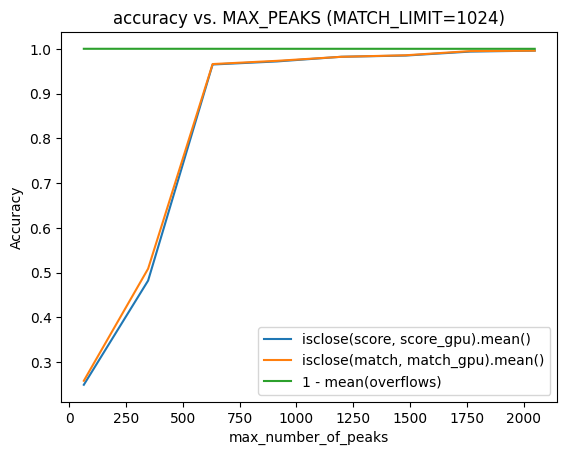

In [31]:
plt.plot(x,np.array(y))
plt.title(f"accuracy vs. MAX_PEAKS (MATCH_LIMIT={MATCH_LIMIT})")
plt.legend(['isclose(score, score_gpu).mean()',
            'isclose(match, match_gpu).mean()',
            "1 - mean(overflows)"])
plt.ylabel("Accuracy")
plt.xlabel("max_number_of_peaks")

Text(0.5, 0, 'max_number_of_peaks')

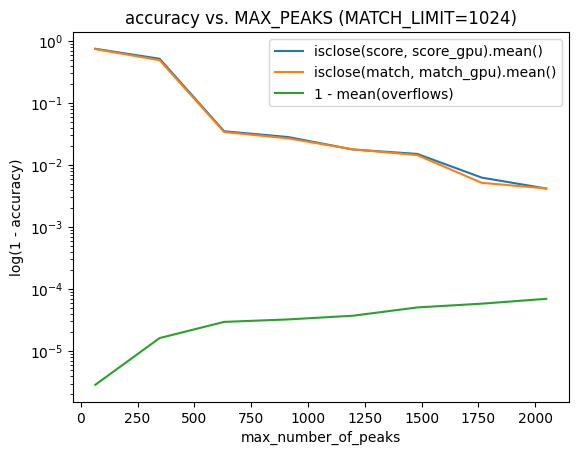

In [32]:
plt.semilogy(x,1-np.array(y))
plt.title(f"accuracy vs. MAX_PEAKS (MATCH_LIMIT={MATCH_LIMIT})")
plt.legend(['isclose(score, score_gpu).mean()',
            'isclose(match, match_gpu).mean()',
            "1 - mean(overflows)"])
plt.ylabel("log(1 - accuracy)")
plt.xlabel("max_number_of_peaks")